In [2]:
import itertools
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp
import contextily as ctx
import folium
import geopy.distance
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from operator import itemgetter

In [3]:
#create dataframe
def create_df(customer_count):
  df = pd.DataFrame({
      'x': np.random.randint(0, 100, customer_count),
      'y': np.random.randint(0, 100, customer_count),
      'demand': np.random.randint(1, 4, customer_count),
      'priority': np.random.randint(1, 2, customer_count),
  })

  df.iloc[0]['x'] = 0
  df.iloc[0]['y'] = 0
  df.iloc[0]['demand'] = 0
  df.iloc[0]['priority'] = 0
  df.iloc[-1]['x'] = 50
  df.iloc[-1]['y'] = 50
  df.iloc[-1]['demand'] = 0
  df.iloc[0]['priority'] = 0

  print(df)
  return df


In [4]:
# get distance matrix
def dist_mat(df):
  distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

  # fig, ax = plt.subplots(figsize=(8, 7))
  # sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
  # plt.title('distance matrix')
  # plt.show()

  return distances

In [5]:
def plot_points(df):
  # check VRP state

  plt.figure(figsize=(5, 5))

  # draw problem state
  for i, row in df.iterrows():
      if i == 0:
          plt.scatter(row['x'], row['y'], c='red')
          plt.text(row['x'] + 1, row['y'] + 1, 'taxi')
      if i == -1:
          plt.scatter(row['x'], row['y'], c='green')
          plt.text(row['x'] + 1, row['y'] + 1, 'hotspot')
      else:
          plt.scatter(row['x'], row['y'], c='black')
          demand = row['demand']
          plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')

  plt.xlim([-10, 110])
  plt.ylim([-10, 110])
  plt.title('points: id(demand)')
  plt.show()

In [6]:
# solve with pulp
def pulp_solve(df, distances, customer_count):
  demands = df['demand'].values

  for vehicle_count in range(1,vehicle_counts+1):

    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1
    # already includes constraint sum(xii) = 0
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]
    u = pulp.LpVariable.dicts('u', (i for i in range(1, customer_count)), lowBound=0, cat='Continuous')

    # add objective function
    problem += pulp.lpSum(distances[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count)
                          for j in range(customer_count)
                          for i in range (customer_count))

  #CONSTRAINTS

    # pickup all points with exactly one cab
    for j in range(1,customer_count-1):
        problem += pulp.lpSum(x[i][j][k] for i in range(customer_count) for k in range(vehicle_count)) == 1


    #depart from Taxi
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 0

    #arrive at Hotspot
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[i][customer_count-1][k] for i in range(customer_count-1)) == 1
        problem += pulp.lpSum(x[customer_count-1][j][k] for j in range(customer_count-1)) == 0

    # demand collected on the route is less than Vehicle Capacity
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j]*x[i][j][k] if i != j else 0
                              for i in range(customer_count) for j in range(customer_count)) <= vehicle_capacity

    #if arrive then leave
    for k in range(vehicle_count):
        for j in range(1,customer_count-1):
            problem += pulp.lpSum( pulp.lpSum(x[i][j][k] for i in range(0,customer_count-1)) ) == ( pulp.lpSum(x[j][m][k] for m in range(1,customer_count)) )

    # Subtour Elimination (MTZ constraints)
    for i in range(1, customer_count):
        problem += u[i] >= 1  # Ensures that each node (except the depot) is visited at least once
        problem += u[i] <= customer_count - 1  # Sets an upper bound for u[i]
    for k in range(vehicle_count):
        for i in range(1, customer_count):
            for j in range(1, customer_count):
                if i != j:
                    problem += u[i] - u[j] + (customer_count - 1) * x[i][j][k] <= customer_count- 2

    # solve problem
    status = problem.solve()
    print(status)

    if status == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('Moving Distance:', pulp.value(problem.objective))
        break

  # visualization : plotting with matplolib

  plt.figure(figsize=(8,8))
  for i in range(customer_count):
      if i == 0:
          plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='green', s=200)
          plt.text(df.iloc[i]['x'], df.iloc[i]['y'], "Depot 1", fontsize=14)
      elif i == customer_count -1:
          plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='red', s=200)
          plt.text(df.iloc[i]['x'], df.iloc[i]['y'], "Hotspot", fontsize=14)
      else:
          plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='orange', s=200)
          plt.text(df.iloc[i]['x'], df.iloc[i]['y'], str(i)+" ("+ str(df.iloc[i]['demand']) + ")", fontsize=10)

  for k in range(vehicle_count):
      for i in range(customer_count):
          for j in range(customer_count):
              if i != j and pulp.value(x[i][j][k]) == 1:
                  plt.arrow(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[j]['x']-df.iloc[i]['x'], df.iloc[j]['y']-df.iloc[i]['y'], head_width=2, head_length=2, fc='black', ec='black')

                  mid_x = (df.iloc[i]['x'] + df.iloc[j]['x']) / 2
                  mid_y = (df.iloc[i]['y'] + df.iloc[j]['y']) / 2
                  plt.text(mid_x, mid_y, f"Cab {k}", ha="center", va="center", fontsize=12, color = 'purple')



  plt.show()


  rejected_list = set()

  for k in range(vehicle_count):
    CP = 0
    SP = 0

    nodes = set()
    for i in range(customer_count-1):
        for j in range(1, customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:

              CP += pulp.value(distances[i][j] * x[i][j][k])

              if i==0 or i==customer_count-1:
                continue
              else:
                SP += distances[i][customer_count-1]*demands[i]
                nodes.add(i)

              i = j
              break
        if i==customer_count-1:
          break

    Gain = 1.5*SP - CP
    print(k, CP, SP, Gain)
    print(nodes)
    if Gain<20:
      rejected_list = set(list(rejected_list) + list(nodes))


  rejected_df = df.iloc[list(rejected_list)]
  rejected_df.drop(rejected_df.priority, axis = 1)
  rejected_df
  print(rejected_df)
  return rejected_df

In [7]:
# define VRP
vehicle_capacity = 3
vehicle_counts = 20
count = 0

In [8]:
def Optimizer(rejected_df):
  global count
  print("Iteration ", count)
  count+=1
  if count==10:
    return
  customer_count = np.random.randint(7, 10)
  df = create_df(customer_count)
  hotspot = df.iloc[[customer_count-1]]
  df = pd.concat([df.iloc[:customer_count-1], rejected_df], ignore_index = True)
  df = pd.concat([df, hotspot], ignore_index = True)
  print(df)

  distances = dist_mat(df)
  plot_points(df)
  rejected = pulp_solve(df, distances, len(df))
  Optimizer(rejected)

Iteration  0
    x   y  demand  priority
0   0   0       0         0
1  22  84       3         1
2  91  28       2         1
3  24  34       2         1
4  96  59       2         1
5  69  59       1         1
6  68  80       1         1
7  18  84       2         1
8  50  50       0         1
    x   y  demand  priority
0   0   0       0         0
1  22  84       3         1
2  91  28       2         1
3  24  34       2         1
4  96  59       2         1
5  69  59       1         1
6  68  80       1         1
7  18  84       2         1
8  50  50       0         1


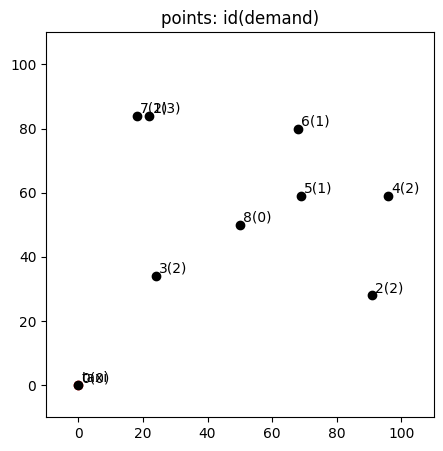

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/prachit/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8e458b07b41b48c99eb4f2c703c237cb-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/8e458b07b41b48c99eb4f2c703c237cb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 96 COLUMNS
At line 739 RHS
At line 831 BOUNDS
At line 904 ENDATA
Problem MODEL has 91 rows, 80 columns and 426 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

-1
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/prachit/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/bcce10286cd547b680a534abb3c90fc8-pulp.mps -timeMode elapsed

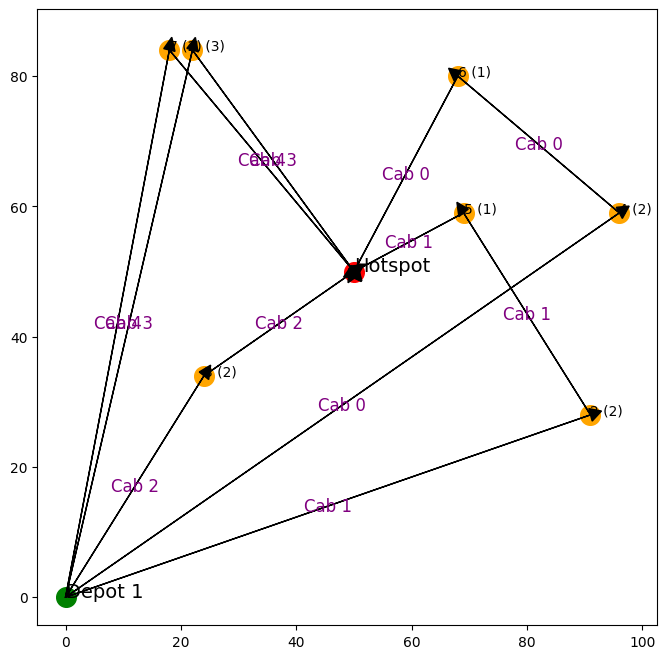

0 182.66667693114 128.73004453113552 10.428389865563304
{4, 6}
1 154.24724522027316 114.08291703468338 16.877130331751914
{2, 5}
2 72.14597913831712 61.05735008989499 19.44004599652537
{3}
3 130.87860447546012 132.13629327327143 67.32583543444701
{1}
4 132.59739649937313 93.38094023943002 7.474013859771901
{7}


KeyError: '[1, 1, 1, 1, 1, 1] not found in axis'

In [9]:
rejected_df = pd.DataFrame()
Optimizer(rejected_df)